# Pytorchを使用したFinetuningによる八重鑑別
参考: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import datasets, transforms, models
import copy
from tqdm import tqdm
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


## パラメータ

In [2]:
# データへのパス hoge/(train/, val/ test/)を想定
dataset_path = './data/splitted_data/8_12_16_18_9_10_12'

# テストデータへのパス hoge/(single/ double/)
target_dir = "./data/splitted_data/10_14_test/test"

# resnet18, efficientnet_b3
base_model_name = "efficientnet_b3"

input_size = 224  # 正方形画像サイズの1辺
batch_size = 8

feature_extracting = False  # 追加した層だけを学習するならTrue
num_classes = 2  # 分類先クラス数

device = torch.device("mps")  # ハードウェア
# device = torch.device("cpu")
print(f"{device=}")

# optimizer パラメータ
lr = 0.001
momentum = 0.9

num_epochs = 10  # 訓練エポック数

# 訓練モデルの保存先
save_dir = './trained_models'
model_name = "Efficientnet_b3_mps.pth"
model_path = os.path.join(save_dir, model_name)

device=device(type='mps')


## Datasetの作成
Data augmentation
* 縦横を9割 ~ 10割でランダムに繰り抜く. (ストックが端のほうに写っていることがあるので下手に割合を増やせない. )
* 最終的にImageNet画像の平均値でNormalizeする. 
* validation dataでは, 切り取りや回転を行わない. 

In [3]:
!pwd

/Users/riken/Documents/stock_2022


In [4]:
# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.9, 1), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
         transforms.Resize(input_size),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# train, val datasetの作成
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}
print(image_datasets['train'].class_to_idx)

# dataloaderの作成
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


## modelの準備

In [5]:
if base_model_name=='resnet18':
    model = models.resnet18(pretrained=True, progress=True)

    # modelの凍結処理
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

    # resnet18は, (Bacth, 512)のtensor を出力するのでLinearをくっつけて2出力に
    num_out_features = model.fc.in_features
    model.fc = nn.Linear(num_out_features, num_classes)

    print(model)
else:
    print(f"{base_model_name=}")

base_model_name='efficientnet_b3'


In [6]:
if base_model_name == 'efficientnet_b3':
    model = models.efficientnet_b3(pretrained=True, progress=True)

    # modelの凍結処理
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

    # 最後の分類ブロックだけ書き換え
    # 本来は1536 -> 1000 の分類を行う.
    # (ソースコードを見て書き換え)
    model.classifier[1]=nn.Linear(1536, num_classes)

    print(model)
else:
    print(f"{base_model_name=}")

/Users/riken/Documents/stock_2022/stock_env_m1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/riken/Documents/stock_2022/stock_env_m1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

## Optimizer
更新するべき重みのみを更新するOptimizerを作成する. デフォルトの設定では, modelに追加された重みは".requires_grad=True"となっている． ".requires_grad"=True の重みのみをoptimizerに渡す. 

* ResNetを特徴抽出で使用する場合, 最終層のみoptimizerに渡す. 
* Finetuningを使用する場合, 全ての重みをoptimizerに渡す. 

In [7]:
# modelをGPUに送る
model = model.to(device)
print(device)

params_to_update = model.parameters()
print("Params to learn: ")

if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

else:
    for name, param in model.named_parameters():
        if param.requires_grad==True:
            print("\t", name)

optimizer = optim.SGD(params_to_update, lr = lr, momentum=momentum)

mps
Params to learn: 
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.0.block.0.0.weight
	 features.1.0.block.0.1.weight
	 features.1.0.block.0.1.bias
	 features.1.0.block.1.fc1.weight
	 features.1.0.block.1.fc1.bias
	 features.1.0.block.1.fc2.weight
	 features.1.0.block.1.fc2.bias
	 features.1.0.block.2.0.weight
	 features.1.0.block.2.1.weight
	 features.1.0.block.2.1.bias
	 features.1.1.block.0.0.weight
	 features.1.1.block.0.1.weight
	 features.1.1.block.0.1.bias
	 features.1.1.block.1.fc1.weight
	 features.1.1.block.1.fc1.bias
	 features.1.1.block.1.fc2.weight
	 features.1.1.block.1.fc2.bias
	 features.1.1.block.2.0.weight
	 features.1.1.block.2.1.weight
	 features.1.1.block.2.1.bias
	 features.2.0.block.0.0.weight
	 features.2.0.block.0.1.weight
	 features.2.0.block.0.1.bias
	 features.2.0.block.1.0.weight
	 features.2.0.block.1.1.weight
	 features.2.0.block.1.1.bias
	 features.2.0.block.2.fc1.weight
	 features.2.0.block.2.fc1.bias
	 features.2.0.block

## Training function

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    output:
    (best_model, list of accuracy per epoch)
    """
    since = time.time()

    val_acc_history = []

    # deepcopy はオブジェクトをメモリの全く別の場所にコピーする
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'{epoch}/{num_epochs-1}')
        print('-'*10)

        # epochごとの学習ステップと検証ステップの処理
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to validation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # trainモードの時だけ, 勾配をためるようにしとく
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(inputs)
                    loss = criterion(logits, labels)
                    _, preds = torch.max(logits, 1)

                    # backwardとoptimizeをtrainの時のみ行う
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # stepでのlossとacc
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.item() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # モデルのdeep copy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## Training and Validation Step

In [9]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

0/9
----------


100%|██████████| 303/303 [03:09<00:00,  1.60it/s]


train Loss: 0.6632 Acc: 0.5879


100%|██████████| 76/76 [09:16<00:00,  7.32s/it]


val Loss: 0.6657 Acc: 0.6358

1/9
----------


100%|██████████| 303/303 [03:11<00:00,  1.58it/s]


train Loss: 0.5375 Acc: 0.7323


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


val Loss: 0.4896 Acc: 0.7649

2/9
----------


100%|██████████| 303/303 [03:12<00:00,  1.58it/s]


train Loss: 0.4323 Acc: 0.8113


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


val Loss: 0.4211 Acc: 0.8113

3/9
----------


100%|██████████| 303/303 [03:11<00:00,  1.59it/s]


train Loss: 0.3489 Acc: 0.8502


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


val Loss: 0.3899 Acc: 0.8262

4/9
----------


100%|██████████| 303/303 [03:15<00:00,  1.55it/s]


train Loss: 0.3061 Acc: 0.8730


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


val Loss: 0.4032 Acc: 0.8063

5/9
----------


100%|██████████| 303/303 [03:13<00:00,  1.57it/s]


train Loss: 0.2634 Acc: 0.8920


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


val Loss: 0.3631 Acc: 0.8493

6/9
----------


100%|██████████| 303/303 [03:17<00:00,  1.54it/s]


train Loss: 0.1950 Acc: 0.9201


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


val Loss: 0.3488 Acc: 0.8593

7/9
----------


100%|██████████| 303/303 [03:13<00:00,  1.57it/s]


train Loss: 0.1740 Acc: 0.9338


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


val Loss: 0.3765 Acc: 0.8311

8/9
----------


100%|██████████| 303/303 [03:14<00:00,  1.56it/s]


train Loss: 0.1422 Acc: 0.9479


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


val Loss: 0.3378 Acc: 0.8626

9/9
----------


100%|██████████| 303/303 [03:10<00:00,  1.59it/s]


train Loss: 0.1360 Acc: 0.9491


100%|██████████| 76/76 [00:37<00:00,  2.01it/s]

val Loss: 0.3591 Acc: 0.8394

Training complete in 47m 7s
Best val Acc: 0.862583


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


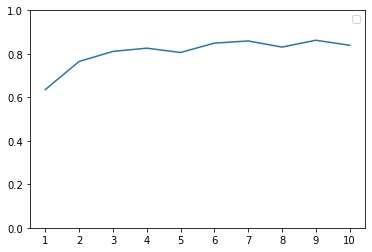

In [10]:
import matplotlib.pyplot as plot
import numpy as np

acc_history = [np.array(h) for h in hist]
plot.plot(range(1, num_epochs+1), acc_history)
plot.ylim((0,1.))
plot.xticks(np.arange(1, num_epochs+1, 1.0))
plot.legend()
plot.show()

In [11]:
torch.save(model, model_path)

In [12]:
import torch
test_ary = torch.ones(2,3)
test_ary2 = torch.ones(2,3)
print(f"{test_ary=}")

device=torch.device('mps')
test_ary = test_ary.to(device)
test_ary2 = test_ary2.to(device)
print(f"{test_ary=}")

test_ary3 = test_ary + test_ary2
print(f"{test_ary3=}")

test_ary3 = test_ary3.to("cpu")
print(f"{test_ary3=}")

test_ary=tensor([[1., 1., 1.],
        [1., 1., 1.]])
test_ary=tensor([[1., 1., 1.],
        [1., 1., 1.]], device='mps:0')
test_ary3=tensor([[2., 2., 2.],
        [2., 2., 2.]], device='mps:0')
test_ary3=tensor([[2., 2., 2.],
        [2., 2., 2.]])


/Users/riken/Documents/stock_2022/stock_env_m1/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


In [80]:
class Stock_Dataset(Dataset):
    def __init__(self, root, transform):

        self.list_label = []

        # 一重画像のパスを取得
        self.list_imgs = list(sorted(os.listdir(os.path.join(root, "single"))))
        # 一重画像の数を保存
        self.single_num = len(self.list_imgs)
        # 八重画像のパスを単画像のパスの後ろに連結
        self.list_imgs.extend(list(sorted(os.listdir(os.path.join(root, "double")))))
        # 八重画像の数を保存
        self.double_num = len(self.list_imgs) - self.single_num

        self.transform = transform

        # ラベルリストの作成
        for _ in range(self.single_num):
            self.list_label.append(0)
        for _ in range(self.double_num):
            self.list_label.append(1)

        
        # root ディレクトリの初期化
        self.root = root

    def __len__(self):
        return len(self.list_label)

    def __getitem__(self, idx):
        # データはラベル0画像が並んだ後、ラベル1画像がならぶ
        # 取り出すindexがどちらのラベル範囲にいるかでパスを変える必要がある
        if idx < self.single_num:
            img_path = os.path.join(self.root, "single", self.list_imgs[idx])
        else:
            img_path = os.path.join(self.root, "double", self.list_imgs[idx])
        img = Image.open(img_path).convert("RGB")

        img = self.transform(img)

        label = self.list_label[idx]

        return img, label



In [113]:
test_dataset = Stock_Dataset(target_dir, data_transforms["val"])
test_loader = DataLoader(test_dataset, 16)

# 重みの読み込み
model=torch.load(model_path)

# 推論
logits_list = []
y_list = []
running_corrects = 0
model.to("cpu")
for datas, labels in tqdm(test_loader):
    datas.to("cpu")
    logits = model(datas)
    # 八重のindexを1にするので確率を入れ替える
    logits_list.extend(1 - logits.detach().numpy())
    y_list.extend(labels.detach().numpy())

100%|██████████| 63/63 [04:14<00:00,  4.04s/it]


In [110]:
# 確率への変換および、閾値ラベリング
prob_list = nn.Softmax().forward(torch.tensor(logits_list))
double_thresh = 0.5
double_label = 1
single_label = 0
pred_list = [double_label if prob[double_label] > double_thresh else single_label for prob in prob_list]
pred_list.count(1)

/Users/riken/Documents/stock_2022/stock_env_m1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  exec(code_obj, self.user_global_ns, self.user_ns)


798

In [111]:
# metrics の計算
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
acc = accuracy_score(y_list, pred_list)
f1 = f1_score(y_list, pred_list)
recall = recall_score(y_list, pred_list)
precision = precision_score(y_list, pred_list)
con_matrix = confusion_matrix(y_list, pred_list)
print(f"{acc=}")
print(f"{recall=}")
print(f"{precision=}")
print(f"{f1=}")
print(f"{con_matrix=}")

acc=0.712
recall=0.9521276595744681
precision=0.6729323308270677
f1=0.7885462555066081
con_matrix=array([[175, 261],
       [ 27, 537]])
